In [1]:
# Imports
import nltk
import csv
import re
import pandas as pd
import numpy as np
from pprint import pprint
import math
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:

negations_dic = { "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
                "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
                "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
                "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
                "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
                "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                "you've": "you have", "ve": "have", "favor":"favour", "favorite":"favourite", "color":"colour",
                "behavior": "behaviour", "labor": "labour", "neighbor": "neighbour", "flavor":"flavour"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()
    def split(self, text):
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences

class POSTagger(object):
    def __init__(self):
        pass
    def pos_tag(self, sentences):
        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos
    
splitter = Splitter()
tok = WordPunctTokenizer()
postagger = POSTagger()
stemmer = SnowballStemmer("english")


pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))


def review_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case=""
    for i in range(0,len(clean)):
        if text[i].isalpha():
            lower_case=lower_case+text[i].lower()
        elif text[i].isdigit():
            lower_case=lower_case
        else:
            lower_case=lower_case+text[i]
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    forpos= " ".join(words).strip()
    splitted_sentences = splitter.split(forpos)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    altered_text=""
    for sentences in pos_tagged_sentences:
        for word in sentences:
            v=word[2]
            for val in v:
                if (val=="JJ" or val=="JJR" or val=="JJS" or val=="VB" or val=="VBD" or val=="VBG"
                    or val=="VBN" or val=="VBP" or val=="VBZ" or val=="RB" or val=="RBR" or val=="RBS" ):
                    altered_text=altered_text+stemmer.stem(word[0])+" "
    return altered_text

In [4]:
# Store imdb movie reviews file in pandas dataframes
cols = ['reviewText','rating']
df = pd.read_csv("IMDB Dataset.csv", header=None, names=cols)
df.head(10)

,reviewText,rating
0,review,sentiment
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative
5,"Petter Mattei's ""Love in the Time of Money"" is...",positive
6,"Probably my all-time favorite movie, a story o...",positive
7,I sure would like to see a resurrection of a u...,positive
8,"This show was an amazing, fresh & innovative i...",negative
9,Encouraged by the positive comments about this...,negative


In [5]:
# Create clean review file 
clean_review_texts = np.empty([1, 2], dtype=object)
for i in range(0,len(df)):
#     print(i)
    clean_review_texts=np.append(clean_review_texts, np.array([[review_cleaner(df.iloc[i]['reviewText']),df.iloc[i]['rating']]]), axis=0)
clean_review_texts=np.delete(clean_review_texts, 0, 0)
clean_df = pd.DataFrame(clean_review_texts,columns=['text','target'])    
clean_df.to_csv('imdbclean_review.csv', encoding='utf-8')

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

my_df = pd.read_csv('imdbclean_review.csv',index_col=0)
cvec = CountVectorizer(dtype='float32')
#cvec.fit(my_df.text)
cvec.fit_transform(my_df['text'].values.astype('U'))
l=len(cvec.get_feature_names())
print("Number of features: ",l)
neg_doc_matrix = cvec.transform(my_df[my_df.target == 'negative'].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 'positive'].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray((neg_tf)))
pos = np.squeeze(np.asarray((pos_tf)))

term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()
term_freq_df.columns = ['negative','positive']
term_freq_df['total'] = term_freq_df['negative'] +term_freq_df['positive']
#document_matrix = cvec.transform(my_df.text)
term_freq_df.to_csv('imdb_term_freq.csv',encoding='utf-8')

term_freq_df_new = pd.read_csv('imdb_term_freq.csv',index_col=0)
#print(term_freq_tfidf)
lexicon_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
lexicon_df.columns = ['negative', 'positive']
for i in range(0,l):
    tot=term_freq_df_new.iloc[i]['total']
    nn=term_freq_df_new.iloc[i]['negative']
    ps=term_freq_df_new.iloc[i]['positive']
    if nn==0:
        lexicon_df.iloc[i]['negative']=0
    elif nn==tot:
        lexicon_df.iloc[i]['negative']=2.5*nn
    else:
        lexicon_df.iloc[i]['negative']=1/(math.log((tot/nn),10))

    if ps==0:
        lexicon_df.iloc[i]['positive']=0
    elif ps==tot:
        lexicon_df.iloc[i]['positive']=2.5*ps
    else:
        lexicon_df.iloc[i]['positive']=1/(math.log((tot/ps),10))
        #print(1/(math.log((tot/ps),10)))
        #print(float(term_freq_tfidff.iloc[i]['positive']))

lexicon_df.to_csv('imdb_lexicon.csv',encoding='utf-8') 


Number of features:  40574


In [10]:
createfeed=pd.read_csv('imdb_lexicon.csv',index_col=0)
columns=["Sno","freq_neg","freq_pos","overall"]
my_df=my_df.fillna("are")
ok=len(my_df)
#print(my_df.isnull())
feature_values=[0,0]
#print(feature_values)

with open('imdb_feed.csv','w') as myfile:
    wr = csv.writer(myfile,quoting=csv.QUOTE_NONE)
    wr.writerow(columns)
    for i in range(0,ok):
        if i%(ok//2)==0:
            print(i)
        feature_values=[0,0]
        text_for_comparison = my_df.iloc[i]['text']
        if text_for_comparison not in (None, " ","are"):
            words= text_for_comparison.split()
            for j in range(0,len(words)):
                if ('nan' not in words) & ('null' not in words) :
                    feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1]])
                else:
                    feature_values = np.add(feature_values,[0,0])
                #print(feature_values)
            feature_values = feature_values.tolist()
            #print(feature_values)
            feature_values.insert(0, i)
#             new_lab=int(my_df.iloc[i]['label']/2)
            new_lab=my_df.iloc[i]['target']
            feature_values.insert(3, new_lab)
            wr.writerow(feature_values)
    

0
25000
50000


In [11]:
import numpy as np
import keras
import keras.utils
from keras.utils import to_categorical
with open('imdb_feed.csv') as f:
    content = f.readlines()
lines = np.array(content) 
num_of_instances = lines.size
print(num_of_instances)
print(lines[0])

Using TensorFlow backend.


50001
Sno,freq_neg,freq_pos,overall



In [13]:
x_all, y_all = [], []
for i in range(1, num_of_instances):
    val = [0, 0]
    s, val[0], val[1], label = lines[i].split(",")
    if label=='positive\n':
        label=1
    elif label=='negative\n':
        label=0

    #print(newlabel)
    final_val = np.array(val, 'float32')
    class_label = keras.utils.to_categorical(label,2)
    #class_label=class_label[0:3]
    y_all.append(class_label)
    x_all.append(final_val)

In [14]:
x_all = np.array(x_all)
print(np.shape(x_all))
y_all = np.array(y_all)
print(np.shape(y_all))
print(y_all)
print(len(x_all))

(50000, 2)
(50000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
50000


In [15]:
from random import shuffle
ind_list = [i for i in range(len(x_all))]
shuffle(ind_list)
x_all  = x_all[ind_list,]
y_all = y_all[ind_list,]

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

modelsentif=Sequential()

modelsentif.add(Dense(6,input_shape=(2,)))
modelsentif.add(Activation("relu"))

modelsentif.add(Dense(2))
modelsentif.add(Activation("softmax"))

In [17]:
modelsentif.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

histsentif = modelsentif.fit(x_all, y_all, epochs=40, batch_size=512, validation_split=0.15, verbose=1)

Train on 42500 samples, validate on 7500 samples
Epoch 1/40
42500/42500 [==============================] - 0s 9us/step - loss: 8.0346 - acc: 0.5010 - val_loss: 8.1818 - val_acc: 0.4921
Epoch 2/40
42500/42500 [==============================] - 0s 4us/step - loss: 7.6017 - acc: 0.5047 - val_loss: 2.3470 - val_acc: 0.5123
Epoch 3/40
42500/42500 [==============================] - 0s 4us/step - loss: 0.4211 - acc: 0.8391 - val_loss: 0.2903 - val_acc: 0.8856
Epoch 4/40
42500/42500 [==============================] - 0s 4us/step - loss: 0.2979 - acc: 0.8812 - val_loss: 0.2923 - val_acc: 0.8856
Epoch 5/40
42500/42500 [==============================] - 0s 4us/step - loss: 0.2943 - acc: 0.8834 - val_loss: 0.2869 - val_acc: 0.8900
Epoch 6/40
42500/42500 [==============================] - 0s 4us/step - loss: 0.2932 - acc: 0.8847 - val_loss: 0.2902 - val_acc: 0.8869
Epoch 7/40
42500/42500 [==============================] - 0s 4us/step - loss: 0.2920 - acc: 0.8852 - val_loss: 0.2868 - val_acc: 0.8884

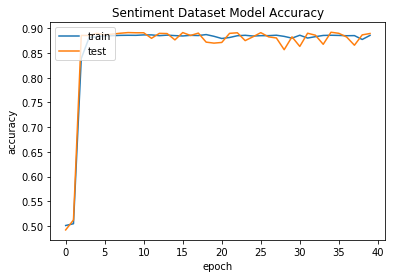

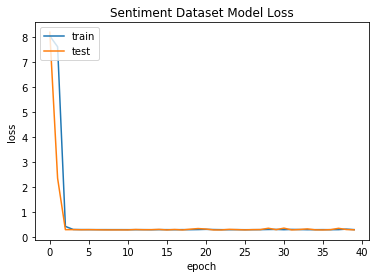

In [18]:
# summarize history for accuracy
plt.plot(histsentif.history['acc'])
plt.plot(histsentif.history['val_acc'])
plt.title('Sentiment Dataset Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histsentif.history['loss'])
plt.plot(histsentif.history['val_loss'])
plt.title('Sentiment Dataset Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# serialize model to JSON
modelsentif_json = modelsentif.to_json()
with open("imdbmodel.json", "w") as json_file:
    json_file.write(modelsentif_json)
# serialize weights to HDF5
modelsentif.save_weights("imdbmodel.h5")
print("Saved model to disk")


from keras.models import model_from_json
# load json and create model
json_file = open('imdbmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("imdbmodel.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
pred_list = []; actual_list = []
predictions = loaded_model.predict(x_all)
for i in predictions:
    pred_list.append(np.argmax(i))
for i in y_all:
    actual_list.append(np.argmax(i))
cnf_matrix=confusion_matrix(actual_list, pred_list)

In [21]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(len(classes))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[21491  3509]
 [ 2155 22845]]
2


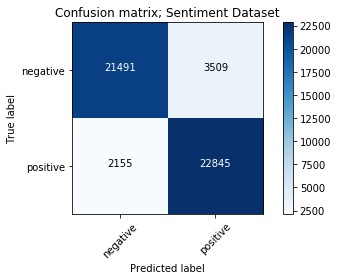

In [22]:
# Plot non-normalized confusion matrix
class_names =['negative','positive']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix; Sentiment Dataset')
plt.show()

In [24]:
# Test model on actual input
import pandas as pd
createfeed=pd.read_csv('imdb_lexicon.csv',index_col=0)
feature_values=[0,0]
str = "I am not enjoying it."
str_result =  review_cleaner(str)
words= str_result.split()
words.insert(0, '')
words.insert(0, '')
print(words)
for j in range(2,len(words)):
    try:
        if (words[j-1]=="not" and words[j-2]!="not") or (words[j-1]!="not" and words[j-2]=="not"):
            feature_values = np.add(feature_values,[createfeed.loc[words[j]][1],createfeed.loc[words[j]][0]])
        else:
            feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1]])
    except:
        continue
feature_values = feature_values.tolist()
test_case = np.array(feature_values)

#print(np.shape(test_case))
checker = []
checker.append(test_case)
checker = np.array(checker)
#print(np.shape(checker))

custom = modelsentif.predict(checker)
print(custom[0])

# Order: negative, neutral, positive

['', '', 'am', 'not', 'enjoy']
[0.474283   0.52571696]
